In [4]:
#All liberies
from numba import njit
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix
from tqdm import tqdm
from pympler import asizeof
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix

In [5]:
def rotate_vec(vector, n):
    rotation_matrices = {
        0: np.array([[1, 0], [0, 1]]),    # 0 degrees
        1: np.array([[0, -1], [1, 0]]),   # 90 degrees
        2: np.array([[-1, 0], [0, -1]]),  # 180 degrees
        3: np.array([[0, 1], [-1, 0]])    # 270 degrees
    }
    
    roated_vector = rotation_matrices[n] @ vector
    return roated_vector


def segment_point(p1,p2):
    v1 = np.array(np.array(p2)-np.array(p1))
    relative_length = np.linalg.norm(v1)/4
    v1 = v1/np.linalg.norm(v1)
    v2 = np.array([0.0,1.0])
    angle = np.arctan2(v1[1], v1[0])
    angle_degrees = np.degrees(angle)
    angle_degrees = angle_degrees % 360
    n = round(angle_degrees / 90) % 4
    vectors_list = [[relative_length, 0.0], 
                    [0.0, relative_length], 
                    [relative_length, 0.0], 
                    [0.0, -relative_length], 
                    [0.0, -relative_length], 
                    [relative_length, 0.0], 
                    [0.0, relative_length]]
    point = np.array(p1)
    points_list = [p1]
    for vectors in vectors_list:
        roatated_vec = rotate_vec(vectors,n)
        point = point + roatated_vec
        points_list.append(np.round(point).tolist())
    return points_list

def new_line(line):
    new_line = []
    for i in range(0,len(line)-1):
        segment_points = segment_point(line[i], line[i+1]) 
        new_line = new_line + segment_points
    new_line.append(line[-1])
    return new_line

def fract(l, line):
    for _i in range(0,l):
        line = new_line(line)
    return line

def plotting_line(l, size):
    line = [[0.0,0.0], [size,0.0]]
    for i in range(0,l+1):
        line = fract(i,line)
        x_cords = [i[0] for i in line]
        y_cords = [i[1] for i in line]
        plt.plot(x_cords,y_cords)
    plt.show()

def plotting_square(l,size):
    for i in range(0,l+1):
        total_points = generate_square_without_shift(i, size)
        x_cords = [i[0] for i in total_points]
        y_cords = [i[1] for i in total_points]
        plt.plot(x_cords,y_cords)
    plt.show()


def generate_square_without_shift(l,size):
    lines = [
        [[0.0, 0.0], [size, 0.0]],  
        [[size, 0.0], [size, size]],
        [[size, size], [0.0, size]],
        [[0.0, size], [0.0, 0.0]]
        ]
    total_points = []
    for line in lines:
        line = fract(l,line)
        total_points = total_points + line
    min_x = min([i[0] for i in total_points])
    min_y = min([i[1] for i in total_points])
    print(min_x,min_y)
    total_points = [i + [min_x,min_y] for i in total_points]
    return total_points

    
def generate_square(l, size):
    lines = [
        [[0.0, 0.0], [size, 0.0]],  
        [[size, 0.0], [size, size]],
        [[size, size], [0.0, size]],
        [[0.0, size], [0.0, 0.0]]
    ]
    
    total_points = []
    
    for line in lines:
        line_points = fract(l, line)  
        total_points.extend(line_points)  

    min_x = min(point[0] for point in total_points)
    min_y = min(point[1] for point in total_points)

    adjusted_points = [[point[0] - min_x, point[1] - min_y] for point in total_points]
    return adjusted_points


0.0 0.0
-16.0 -16.0
-20.0 -20.0
-21.0 -21.0


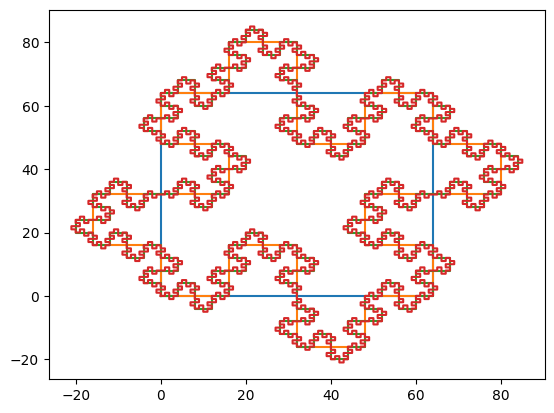

In [6]:
plotting_square(3,4**3)

In [7]:
def does_intersect(x1,x2,point):
    if x1[1] > x2[1]:
        x1, x2 = x2, x1
        
    if x1[1] <= point[1] < x2[1]: 
        x_intersect = (point[1] + 0.001 - x1[1]) * (x2[0] - x1[0]) / (x2[1] - x1[1]) + x1[0]
        return x_intersect > point[0] 
    return False



def in_boundry(point,boundry): 
    boundry = np.array(boundry)   
    n = len(boundry)
    num_of_intersect = 0
    for i in range(n):
        p1 = boundry[i]
        p2 = boundry[(i+1)%n]
        if does_intersect(p1,p2, point) :
            num_of_intersect +=1
    return num_of_intersect % 2 == 1

def in_boundry_vecotrized(points, boundry):
    boundry = np.array(boundry)
    n = len(boundry)
    num_of_intersect = np.zeros(len(points), dtype=int)

    for i in range(n):
        p1 = boundry[i]
        p2 = boundry[(i + 1) % n]
        intersects = np.array([does_intersect(p1, p2, point) for point in points])
        num_of_intersect += intersects

    return num_of_intersect % 2 == 1

In [71]:
def generate_grid(l):
    size = 4**l
    if l < 3:
        size = 4**3
    boundry = generate_square(l, size)
    x_boundry = [i[0] for i in boundry]
    y_boundry = [i[1] for i in boundry]
    min_x = int(min(x_boundry))
    max_x = int(max(x_boundry))
    min_y = int(min(y_boundry))
    max_y = int(max(y_boundry))
    grid_x = [i for i in range(min_x,max_x)]
    grid_y = [i for i in range(min_y,max_y)]
    grid_z = [in_boundry([x, y], boundry) for y in grid_y for x in grid_x]
    grid = np.array([[grid_x[j], grid_y[i], grid_z[i * len(grid_x) + j]] for i in range(len(grid_y)) for j in range(len(grid_x))])
    return grid, boundry

In [ ]:
def discrete_laplacian(vector_length, row_length):
    total_array = []
    for i in range(vector_length):
        new_array = np.zeros(vector_length)
        
        next_x = i + 1
        next_y = i + row_length
        previous_x = i - 1
        previous_y = i - row_length
        
        if next_x < vector_length and (i % row_length) < (row_length - 1):
            new_array[next_x] = -1
        if next_y < vector_length and (i // row_length) < (row_length - 1):
            new_array[next_y] = -1
        if previous_x >= 0 and (i % row_length) > 0:  
            new_array[previous_x] = -1
        if previous_y >= 0 and (i // row_length) > 0: 
            new_array[previous_y] = -1
        
        new_array[i] = 4 
        total_array.append(new_array)
    
    return np.array(total_array), row_length

def system_laplacian(vector_length, row_length, boundry):
    laplacian_matrix = discrete_laplacian(vector_length, row_length)[0]
    points_list = []
    points_outside = []
    for i in range(0,vector_length):
        point = [i % row_length, i // row_length]
        points_list.append(point)
        if not in_boundry(point, boundry):
            laplacian_matrix[i] = np.zeros(vector_length)
            points_outside.append(point)
    return laplacian_matrix, points_outside, points_list


def sparse_discrete_laplacian(vector_length, row_length, grid):
    laplacian_matrix = lil_matrix((vector_length, vector_length))
    for i in range(len(grid)):
        if grid[i, 2] == 1:
            next_x = i + 1
            next_y = i + row_length
            previous_x = i - 1
            previous_y = i - row_length

            if next_x < vector_length and (i % row_length) < (row_length - 1) and grid[next_x, 2] == 1:
                laplacian_matrix[i, next_x] = -1
            if next_y < vector_length and (i // row_length) < (row_length - 1) and grid[next_x, 2] == 1:
                laplacian_matrix[i, next_y] = -1
            if previous_x >= 0 and (i % row_length) > 0 and grid[next_x, 2] == 1:
                laplacian_matrix[i, previous_x] = -1
            if previous_y >= 0 and (i // row_length) > 0 and grid[next_x, 2] == 1:
                laplacian_matrix[i, previous_y] = -1

            laplacian_matrix[i, i] = 4

    return laplacian_matrix




$dd = \frac{U_{n-1,m} + U_{n+1,m} + U_{n,m-1} + U_{n,m-1} - 4U_{n,m}}{h^2} $ 

In [ ]:
def find_ram_procentage(grid):
    total_ram = 15.7*10**9
    print("Done with genereating grid")
    x_collum = [i[0] for i in grid]
    laplician  = sparse_discrete_laplacian(len(grid),max(x_collum)+1, grid)

    procent_of_ram = asizeof.asizeof(laplician) / total_ram * 100
    print(procent_of_ram, "%") 


In [67]:
grid, _ = generate_grid(3)
print(len(grid))
find_ram_procentage(grid)

11236
Done with genereating grid
0.0011508789808917198 %


In [11]:
#x_points = [points[0] for points in points_outside]
#y_points = [points[1] for points in points_outside]
#plt.scatter(x_points,y_points)

In [90]:
def find_eiegenvalues(laplacian, number_of_values = 300):
    eigenvalues, eigenvectors = eigsh(laplacian, k=number_of_values, which='SM')
    print("E-value: ", eigenvalues)
    return eigenvalues, eigenvectors

In [ ]:
def plotting_eigenvectors(eigenvectors,boundry):
    x_boundry = [i[0] for i in boundry]
    y_boundry = [i[1] for i in boundry]


    max_dim = int(np.sqrt(len(eigenvectors[:,0])))

    for i in range(0,10):
        vibrations = eigenvectors[:, i].reshape(max_dim,max_dim)
        plt.imshow(vibrations, extent=(0, max_dim, 0, max_dim), origin='lower', cmap='viridis', aspect='auto')
        plt.plot(x_boundry,y_boundry, color="r")
        plt.show()


E-value:  [0.01998051 0.04232338 0.04452305 0.04594388 0.0465584  0.05200694
 0.05236463 0.07107959 0.08100933 0.08501986 0.08564105 0.08971861
 0.09619202 0.10462536 0.10611153 0.10673386 0.12412499 0.12688317
 0.13915213 0.1399944  0.14764659 0.14848709 0.15532074 0.15617494
 0.1752621  0.17722173 0.17772784 0.17856162 0.17924664 0.17984024
 0.18056895 0.18819223 0.20701638 0.21694772 0.2173213  0.22882601
 0.22891266 0.23091012 0.2321109  0.23229391 0.24345018 0.25316065
 0.25519756 0.25904223 0.26208291 0.2668819  0.2691605  0.27426291
 0.28158614 0.2917301  0.293123   0.29377081 0.29685296 0.30680807
 0.30764487 0.31026503 0.31093092 0.32412002 0.32528264 0.32896392
 0.33558967 0.33883395 0.34568193 0.34650495 0.35469021 0.358564
 0.36012651 0.36028261 0.36581777 0.3809141  0.38162437 0.38298937
 0.39412349 0.39469832 0.39716242 0.39882543 0.40407218 0.41165579
 0.41194589 0.42036688 0.42687169 0.42867248 0.43624367 0.43842983
 0.44894722 0.45110107 0.45318956 0.45811353 0.4720341

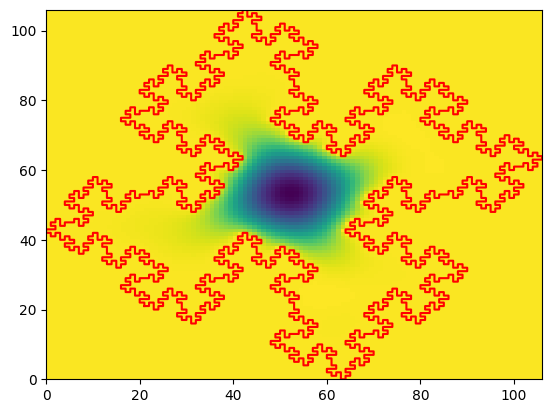

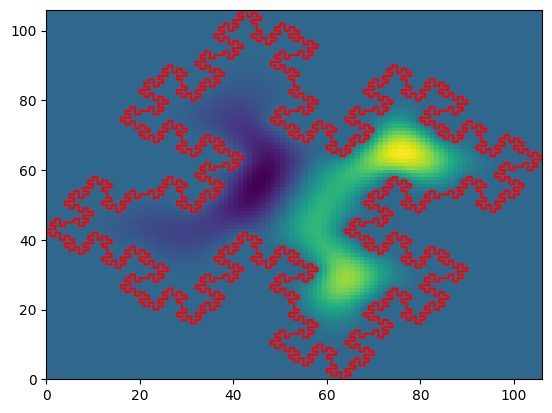

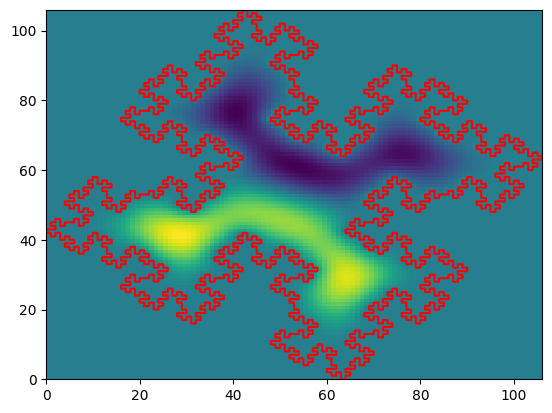

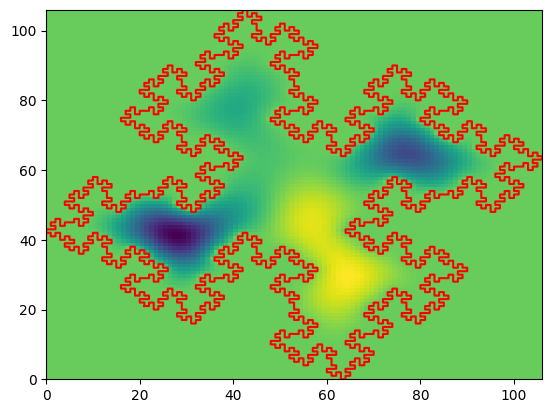

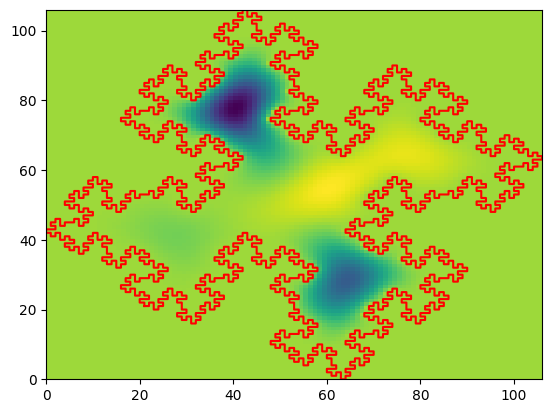

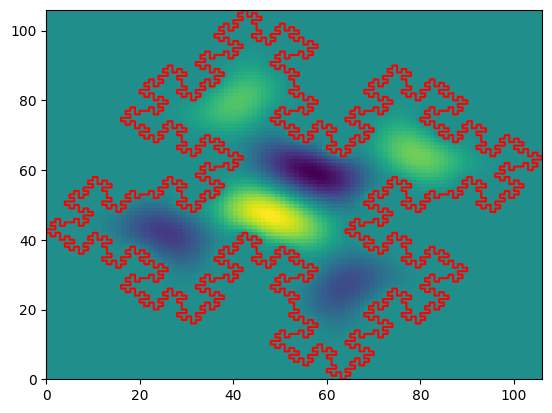

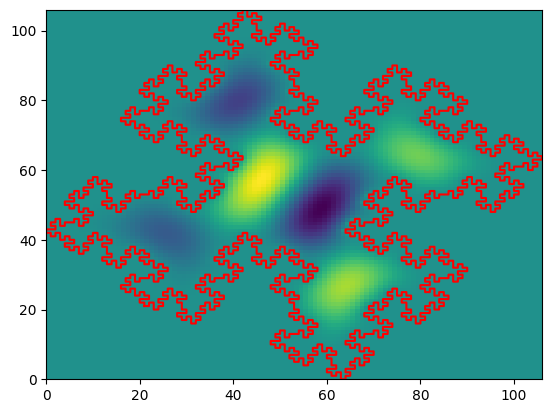

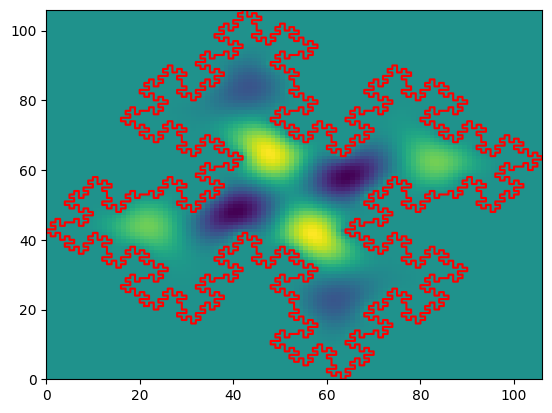

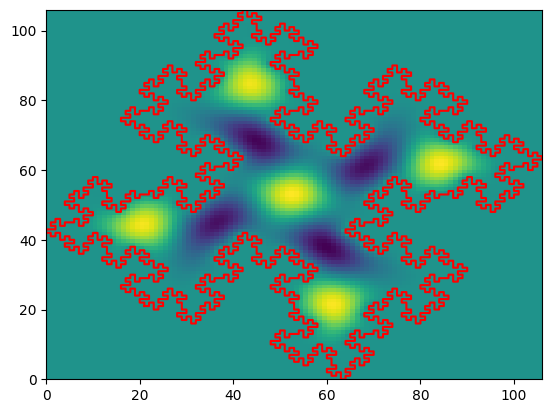

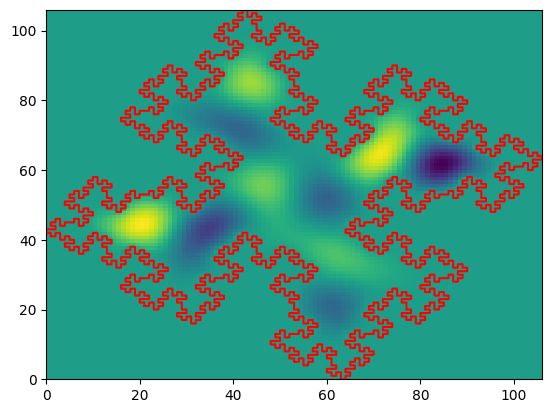

In [74]:
grid, boundry =generate_grid(3)
x_collum = grid[:,0]
lapliacian = sparse_discrete_laplacian(len(grid),max(x_collum)+1, grid)
eigenvalues, eigenvectors = find_eiegenvalues(lapliacian)
plotting_eigenvectors(eigenvectors,boundry)

In [80]:
def finding_d(eigenvalues):
    eigenvalues_set = np.array(list(set(eigenvalues)))
    eigenvalues_set.sort()
    log_eigenvalues = [np.log(i) for i in eigenvalues_set][10:]
    x_axis  = [np.log(i) for i in range(1, len(eigenvalues_set)+1)][10:]
    plt.plot(x_axis, log_eigenvalues)
    coefficients = np.polyfit(x_axis, log_eigenvalues, 1)
    f_x = lambda x: coefficients[0]*x+coefficients[1]
    v_f_x = np.vectorize(f_x)
    plt.plot ( x_axis, v_f_x(x_axis))
    plt.show()
    scalar = 1/coefficients[0]
    print("Scaling of deltaN: ", scalar)
    return scalar

In [ ]:
def find_scaling_for_different_l(l_values, lapliacian_func=sparse_discrete_laplacian):
    scalings = {}
    for l in l_values:
        grid, boundry = generate_grid(l)
        x_collum = [i[0] for i in grid]
        laplacian = lapliacian_func(len(grid), max(x_collum) + 1, grid)
        eigenvalues, _ = find_eiegenvalues(laplacian)
        scaling = finding_d(eigenvalues)
        scalings[l] = scaling
        print(f"Scaling for l={l}: {scaling}")
    
    plt.plot(l_values,scalings.values())
    plt.title("Scaling of deltaN for different l")
    plt.show()
    return scalings

# Example usage:
l_values = [1, 2, 3]
scalings = find_scaling_for_different_l(l_values)
print(scalings)

KeyboardInterrupt: 

In [87]:
def higher_order_laplacian(vector_length, row_length, grid):
    #Here the 1/12 term is extracted from the laplacian matrix to avoid fractions
    laplacian_matrix = lil_matrix((vector_length, vector_length))
    for i in range(len(grid)):
        if grid[i, 2] == 1:
            next_x = i + 1
            next_y = i + row_length
            previous_x = i - 1
            previous_y = i - row_length
            next_next_x = i + 2
            next_next_y = i + 2 * row_length
            previous_previous_x = i - 2
            previous_previous_y = i - 2 * row_length

            if next_x < vector_length and (i % row_length) < (row_length - 1) and grid[next_x, 2] == 1:
                laplacian_matrix[i, next_x] = -16
            if next_y < vector_length and (i // row_length) < (row_length - 1) and grid[next_y, 2] == 1:
                laplacian_matrix[i, next_y] = -16
            if previous_x >= 0 and (i % row_length) > 0 and grid[previous_x, 2] == 1:
                laplacian_matrix[i, previous_x] = -16
            if previous_y >= 0 and (i // row_length) > 0 and grid[previous_y, 2] == 1:
                laplacian_matrix[i, previous_y] = -16

            if next_next_x < vector_length and (i % row_length) < (row_length - 2) and grid[next_next_x, 2] == 1:
                laplacian_matrix[i, next_next_x] = 1
            if next_next_y < vector_length and (i // row_length) < (row_length - 2) and grid[next_next_y, 2] == 1:
                laplacian_matrix[i, next_next_y] = 1
            if previous_previous_x >= 0 and (i % row_length) > 1 and grid[previous_previous_x, 2] == 1:
                laplacian_matrix[i, previous_previous_x] = 1
            if previous_previous_y >= 0 and (i // row_length) > 1 and grid[previous_previous_y, 2] == 1:
                laplacian_matrix[i, previous_previous_y] = 1

            laplacian_matrix[i, i] = 60

    return laplacian_matrix
    

E-value:  [0.23543311 0.5010697  0.5010697  0.51916054 0.52847508 0.60319749
 0.60319749 0.81603602 0.92565145 0.97856509]
E-value:  [0.23543311 0.5010697  0.5010697  0.51916054 0.52847508 0.60319749
 0.60319749 0.81603602 0.92565145 0.97856509]


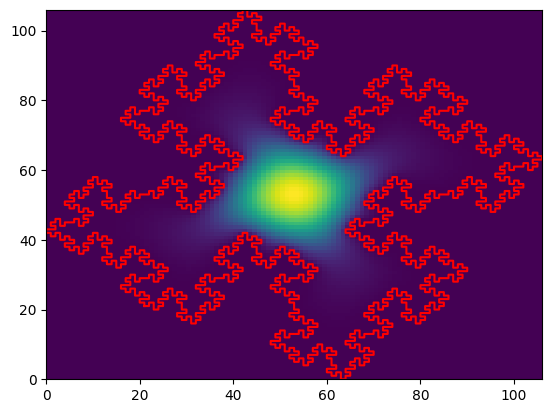

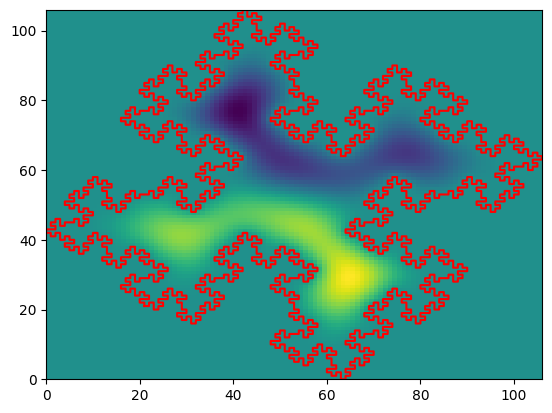

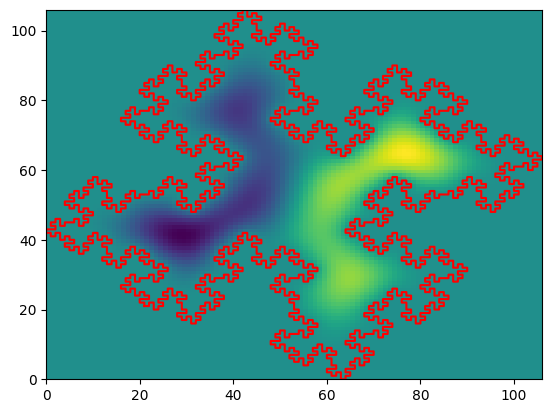

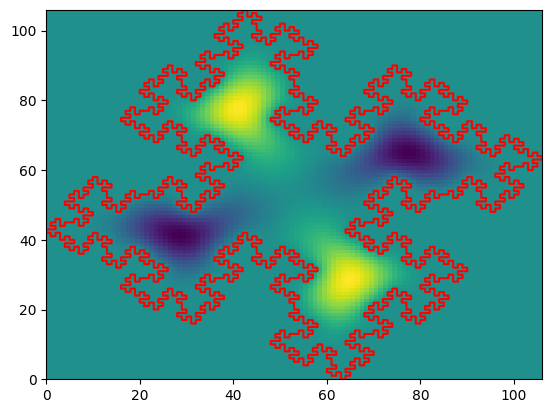

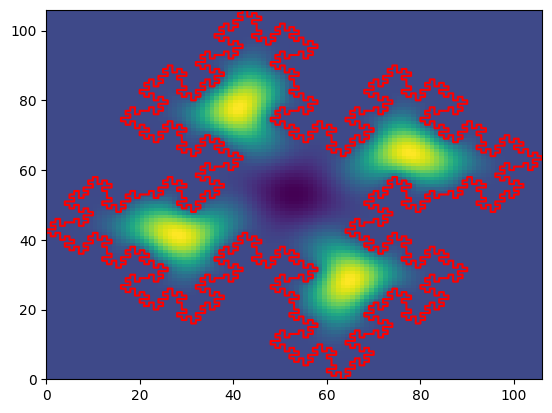

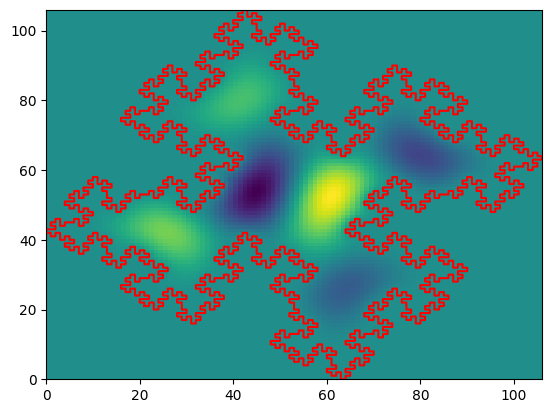

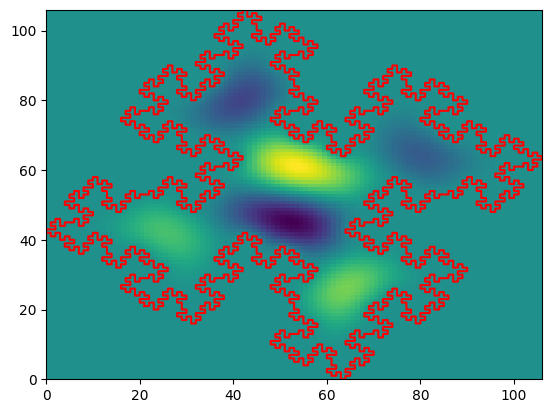

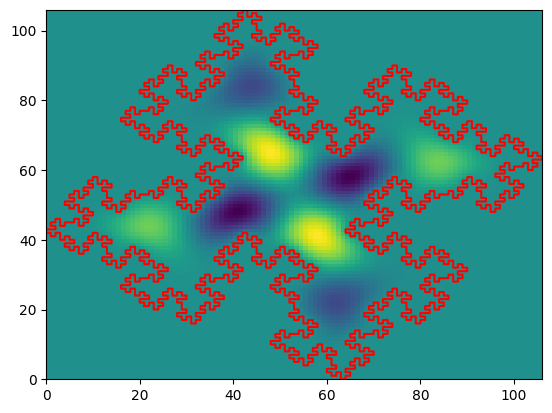

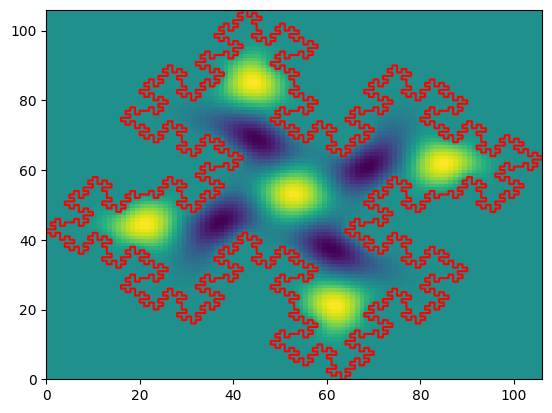

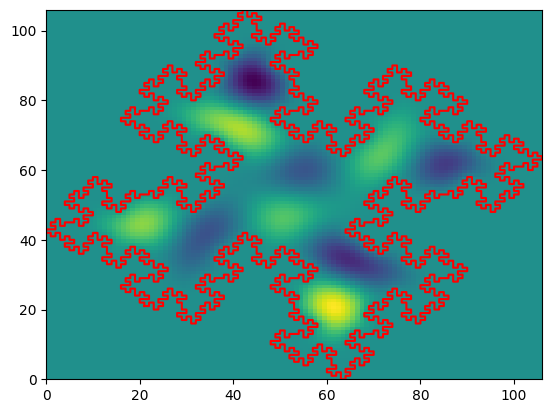

Second order central difference:  0.23543310730233769 Forth order order central difference:  0.2354331073023503 Difference:  -1.2601031329495527e-14
Second order central difference:  0.5010696977442429 Forth order order central difference:  0.5010696977442387 Difference:  4.218847493575595e-15
Second order central difference:  0.5010696977442486 Forth order order central difference:  0.5010696977442418 Difference:  6.772360450213455e-15
Second order central difference:  0.5191605408979066 Forth order order central difference:  0.5191605408979123 Difference:  -5.662137425588298e-15
Second order central difference:  0.5284750783038781 Forth order order central difference:  0.5284750783038861 Difference:  -7.993605777301127e-15
Second order central difference:  0.6031974935371092 Forth order order central difference:  0.6031974935371068 Difference:  2.3314683517128287e-15
Second order central difference:  0.6031974935371144 Forth order order central difference:  0.6031974935371257 Differe

In [94]:
grid, boundry =generate_grid(3)
x_collum = grid[:,0]
lapliacian_1 = sparse_discrete_laplacian(len(grid),max(x_collum)+1, grid)
lapliacian_2 = higher_order_laplacian(len(grid),max(x_collum)+1, grid)
eigenvalues_1, eigenvectors_1 = find_eiegenvalues(lapliacian, 10)
eigenvalues_2, eigenvectors_2 = find_eiegenvalues(lapliacian_2, 10)
plotting_eigenvectors(eigenvectors,boundry)
for i in range(len(eigenvalues_1)):
    print("Second order central difference: ", eigenvalues_1[i], "Forth order order central difference: ", eigenvalues_2[i], "Difference: ", eigenvalues_1[i]-eigenvalues_2[i])
